## Tutorial 8: Video Compression Techniques
### Motivation
How to compress a video (i.e. a time-ordered sequence of images)

<img src="fig/video.gif" width="250" height="250" />

### Alternative 1: Store a video as independent frames 

# of frames 24
# of non-negative pixels 4718589


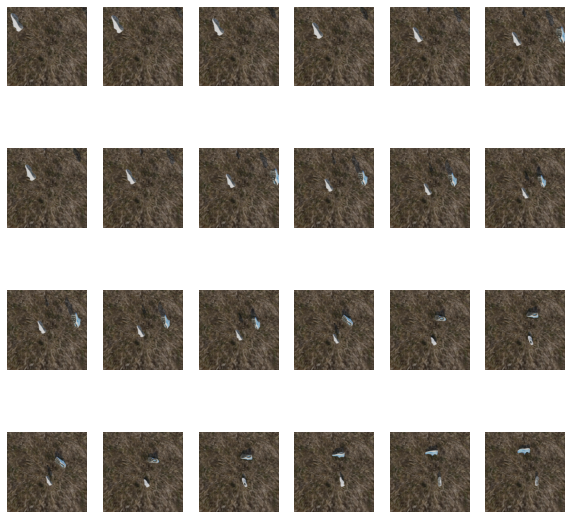

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
non_negative_pixels = 0
img_list = []
for fname in sorted(os.listdir('image_sequence')):
    img = cv2.imread(os.path.join('image_sequence', fname))
    non_negative_pixels += np.sum(img != 0)
    img_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print("# of frames", len(os.listdir('image_sequence')))
print('# of non-negative pixels', non_negative_pixels)

## visualize video frames
f, axarr = plt.subplots(4,6, figsize=(10, 10))
for row in range(0, 4):
    for col in range(0, 6):
        axarr[row,col].imshow(img_list[3*row+col])
        axarr[row,col].axis('off')


### Alternative 2: Store differences between frames
- Consecutive frames are similar, i.e. temporal redundancy exists.
- Not every frame needs to be coded independently as a new image. 

# of frames 24
# of non-negative pixels 1406233


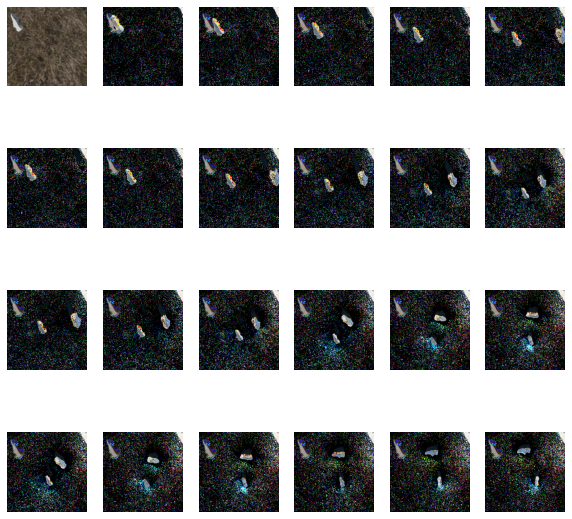

In [2]:
fname_list = sorted(os.listdir('image_sequence'))
init_img = cv2.imread(os.path.join('image_sequence', fname_list[0]))
non_negative_pixels = 0
non_negative_pixels += np.sum(init_img != 0)
img_list = []
img_list.append(cv2.cvtColor(init_img, cv2.COLOR_BGR2RGB))
for fname in fname_list[1:]:
    img = cv2.imread(os.path.join('image_sequence', fname))
    difference = init_img - img
    non_negative_pixels += np.sum(difference != 0)
    img_list.append(difference)
print("# of frames", len(os.listdir('image_sequence')))
print('# of non-negative pixels', non_negative_pixels)

## visualize initial frame and differences
f, axarr = plt.subplots(4,6, figsize=(10, 10))
for row in range(0, 4):
    for col in range(0, 6):
        axarr[row,col].imshow(img_list[3*row+col])
        axarr[row,col].axis('off')

### Alternative 3: Motion Compensation

#### Assumptions behind Motion Compensation
- Difference between frames is caused by camera and/or object motion.
- We can estimate and compensate the motions.
- Thus, the differences to be coded is less. 
<img src="fig/motion_compensation.png" width="300">
<em style="text-align: center;">
    (a) The original frame;
    (b) the difference between two consecutive frames 
    (c) the compensated frame 
    (d) the error in compensation which is lowered compared to (b).</em>


#### General pipeline for Motion Compensation
- Base on `Current Frame`/`Target Frame` $I(T=t)$.
- Refer to an adjance `Reference Frame` $I(T=t+1)$ (or $I(T=t-1)$).
- Estimate `Motion Vector` by comparing `Target Frame` and `Reference Frame`.
- Compensate for the motion by applying `Motion Vector` onto `Target Frame`, which yields `estimated Reference Frame` $\hat{I}(T=t+1)$.
- Code only the difference between $I(T=t+1)$ and $\hat{I}(T=t+1)$.
- Diff($I(T=t+1)$, $\hat{I}(T=t+1)$) < Diff($I(T=t+1)$, $I(T=t)$), since we have compensated motions.

### Block-based Motion Estimation
How to Estimate `Motion Vector` by comparing `Target Frame` and `Reference Frame`.

<img src="fig/fig1.png" width="200">
$$(u, v)=[(i, j) \mid M A D(i, j) \text { is minimum, } i \in[-p, p], j \in[-p, p]]$$
$$M A D(i, j)=\frac{1}{N^2} \sum_{k=0}^{N-1} \sum_{l=0}^{N-1}|C(x+k, y+l)-R(x+i+k, y+j+l)|$$

In [3]:
def MAD(block1, block2):
    diff = np.absolute(block1-block2)
    out = diff.mean()
    return out

#### Full Block Search
sequentially search the whole (2𝑝+1) ∗(2𝑝+1) window in the reference frame

In [4]:
def full_block_search(current_frame, reference_frame, x0, y0, p, N):
    current_block = current_frame[y0-int(N/2):y0+int(N/2), x0-int(N/2):x0+int(N/2)]
#     plt.imshow(current_block, cmap='gray')
    min_mad = np.inf
    best_block = None
    u = None
    v = None
    for i in range(-p, p):
        for j in range(-p, p):
            x = x0 + i
            y = y0 + j
            if x-int(N/2) < 0 or x+int(N/2) > current_frame.shape[0]:
                continue
            if y-int(N/2) < 0 or y+int(N/2) > current_frame.shape[1]:
                continue
            reference_block = reference_frame[y-int(N/2):y+int(N/2), x-int(N/2):x+int(N/2)]
            mad = MAD(current_block, reference_block)
            if mad < min_mad:
                best_block = reference_block
                min_mad = mad
                u = i
                v = j
#     plt.imshow(best_block, cmap='gray')
    return u, v

(256, 256)

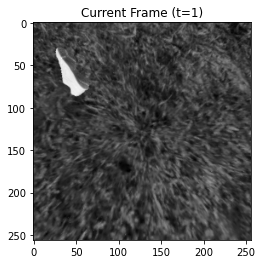

In [5]:
current_frame = cv2.imread('image_sequence/rgba_00001.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(current_frame, cmap='gray')
plt.title("Current Frame (t=1)" )
current_frame.shape

(256, 256)

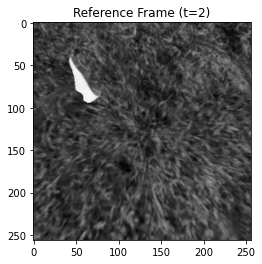

In [6]:
reference_frame = cv2.imread('image_sequence/rgba_00002.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(reference_frame, cmap='gray')
plt.title("Reference Frame (t=2)" )
current_frame.shape

Text(0.5, 1.0, 'Current Frame (t=1)')

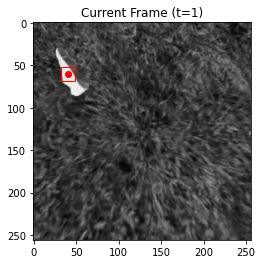

In [7]:
import matplotlib.patches as patches
x0 = 40
y0 = 60
N = 16
p = 50
rect = patches.Rectangle((x0-int(N/2), y0-int(N/2)), N, N, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.scatter([x0], [y0], color="red") # plotting single point
plt.imshow(current_frame, cmap='gray')
plt.title("Current Frame (t=1)" )

13 4


Text(0.5, 1.0, 'Reference Frame (t=2)')

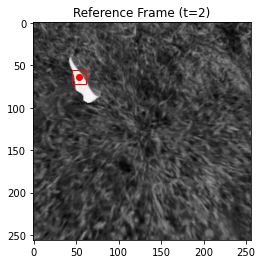

In [8]:
u,v = full_block_search(current_frame, reference_frame, x0=x0, y0=y0, p=p, N=N)
print(u, v)
rect = patches.Rectangle((x0+u-int(N/2), y0+v-int(N/2)), N, N, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.scatter([x0+u], [y0+v], color="red") # plotting single point
plt.imshow(reference_frame, cmap='gray')
plt.title("Reference Frame (t=2)" )

#### Logarithmic Block Search
<img src="fig/fig2.png" width="200">

- Initially only nine locations in the search window are used as seeds for a MAD-based search.
- After the one that yields the minimum MAD is located, the centre of the new search region is moved to it and the step-size is reduced to half.

In [9]:
def logarithmic_block_search(current_frame, reference_frame, x0, y0, p, N):
    current_block = current_frame[y0-int(N/2):y0+int(N/2), x0-int(N/2):x0+int(N/2)]
    x_center = x0
    y_center = y0
    step_size = p
    while step_size > 1:
        min_mad = np.inf
        u = None
        v = None
        seeds = np.linspace(-step_size, step_size, 5, endpoint=True)[1:-1]
        seeds = seeds.astype(int)
        assert len(seeds) == 3
        for i in seeds:
            for j in seeds:
                x = x_center + i
                y = y_center + j
                if x-int(N/2) < 0 or x+int(N/2) > current_frame.shape[0]:
                    continue
                if y-int(N/2) < 0 or y+int(N/2) > current_frame.shape[1]:
                    continue
                reference_block = reference_frame[y-int(N/2):y+int(N/2), x-int(N/2):x+int(N/2)]
                mad = MAD(current_block, reference_block)
                if mad < min_mad:
                    min_mad = mad
                    u = i
                    v = j
        x_center = x_center + u
        y_center = y_center + v
        step_size = int(step_size/2)
    return x_center-x0, y_center-y0

13 4


Text(0.5, 1.0, 'Reference Frame (t=2)')

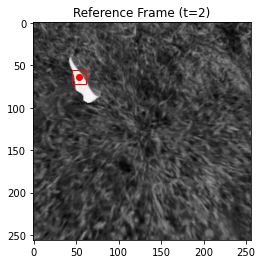

In [10]:
u,v = logarithmic_block_search(current_frame, reference_frame, x0=x0, y0=y0, p=p, N=N)
print(u, v)
rect = patches.Rectangle((x0+u-int(N/2), y0+v-int(N/2)), N, N, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.scatter([x0+u], [y0+v], color="red") # plotting single point
plt.imshow(reference_frame, cmap='gray')
plt.title("Reference Frame (t=2)" )

<strong>Note: </strong>
    There is no guarantee that the estimated motion is always correct
 - We are just looking for the most similar block in a neighborbood area.
 - The accuracy of motion estimation only has effection on the compression ratio.
 - The original video can be recovered no matter how accurate motion estimation is.

10 -2


Text(0.5, 1.0, 'Reference Frame (t=2)')

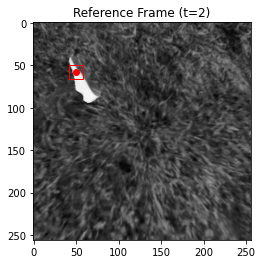

In [11]:
## lets modify the value of p from 50 -> 40
x0 = 40
y0 = 60
N = 16
# p = 50
p = 40 
u,v = logarithmic_block_search(current_frame, reference_frame, x0=x0, y0=y0, p=p, N=N)
print(u, v)
rect = patches.Rectangle((x0+u-int(N/2), y0+v-int(N/2)), N, N, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.scatter([x0+u], [y0+v], color="red") # plotting single point
plt.imshow(reference_frame, cmap='gray')
plt.title("Reference Frame (t=2)" )

### Take home exercise:  Effect of Motion Compensation
Compare (i) the difference between $I(T=1)$ and $I(T=2)$ with (ii) the difference between $I(T=2)$ and motion compensated frame $\hat{I}(T=2)$